<a href="https://colab.research.google.com/github/Al3pr6/Programming-Project/blob/release-3.0/Proyecto_III_Etapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica | TEC
# Carrera de Ingeniería en Computación 
# I Semestre de 2023
# Proyecto Programado (III Fase – Entrevistador asistido por IA) 
# Dr. Abel Méndez Porras
# amendez@itcr.ac.cr
# Porcentaje: 20%

# Entrevistador asistido por IA



El reconocimiento facial y la detección de emociones son tecnologías que se han vuelto cada vez más populares en los últimos años. Estas tecnologías utilizan algoritmos de inteligencia artificial para analizar imágenes y detectar patrones faciales que permiten identificar a las personas y sus emociones.
En cuanto a las oportunidades, el reconocimiento facial puede tener aplicaciones en la seguridad, el marketing y la atención al cliente. Por ejemplo, en la seguridad se pueden utilizar sistemas de reconocimiento facial para identificar a personas en lugares públicos o para controlar el acceso a edificios y sistemas de seguridad. En el marketing, se pueden utilizar para personalizar la publicidad en función de la edad, el género y otros datos demográficos. Y en la atención al cliente, se pueden utilizar para detectar la satisfacción del cliente en tiempo real y responder adecuadamente.

En esta tercera fase del proyecto del curso de Taller de Programación estaremos utilizando los resultados de consultas a modelos de Deep Learning para aplicar los conocimientos adquiridos en clase. Estaremos utilizando los requerimientos desarrollados para la segunda fase del proyecto. Sin embargo, se estarán utilizando widgets para hacer la recolección y mostrar la información para cada requerimiento desarrollado en la segunda fase. Además, se incluyen el manejo de árboles binarios para hacer busqueda de información. 

## Objetivo
Desarrollar una aplicación de complejidad baja que permita poner en práctica los conocimientos adquiridos en los cursos de Introducción a la Programación y Taller de Programación.

## Objetivos Específicos
*  Identificar los requerimientos para resolver un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.
*  Diseñar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.
*  Desarrollar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas, diccionarios, clases, objetos, archivos, árboles binarios y widgets.

## Configuración previa 

### Cargar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Leer cámara
Tomado de https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb



### Importar dependencies

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab import widgets
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from ipywidgets import widgets
import cv2
import numpy as np
import PIL
import io
import html
import time
import pickle
import os
import shutil
import gdown

### Convertir el objeto JavaScript un objeto OpenCV image

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Crear nuestro live video stream

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Iniciar streaming video

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

### Cargar modelos de Deep Learning entrenados

*   Para detectar los rostros se utiliza el modelo de Face Haar Cascade.
*   Para detectar las emociones se utiliza el modelo de VGG.
*   También se utiliza un algoritmo adicional para pasar la información del algortimo de VGG a un formato JSON.

Estos modelos y algoritmos están disponibles en el siguiente enlace [Descargar modelos y algoritmos](https://drive.google.com/drive/folders/1KctA_s25bqqMOUlQuy0lwTm0HkBGVycF?usp=sharing). Usted los debe colocar en su Google Drive y modificar la ruta de acceso. 



In [ ]:
#Cargar modelos de Deep Learning entrenados
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Intro/Proyecto/haarcascade_frontalface_alt.xml') 
model = model_from_json(open("/content/drive/MyDrive/Intro/Proyecto/model.json", "r").read()) 
model.load_weights('/content/drive/MyDrive/Intro/Proyecto/model.h5')

Crear interfaz
https://www.youtube.com/watch?v=oIVmV41uyK8

#Perfiles del Entrevistador Personal

El entrevistador personal es una herramienta para recolectar información de personas que están aplicando a un puesto. En la aplicación existen tres perfiles el entrevistador, el entrevistado y el evaluador. La información de estos perfiles debe ser almacenada en clases y usando herencia. Debe existir una clase "padre" que tiene propiedades y métodos que comparten todos los perfiles. Para cada perfil debe existir una clase subordinada que hereda las propiedades de la clase "padre", además, tiene sus propias propiedades y métodos.

##Cargar Archivos

In [ ]:
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistador'
destino_colab = '/content/Archivo_Entrevistador'
shutil.copyfile(archivo_drive, destino_colab)

# Archivo Evaluador
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Evaluador'
destino_colab = '/content/Archivo_Evaluador'
shutil.copyfile(archivo_drive, destino_colab)

# Archivo Entrevistado
archivo_drive = '/content/drive/MyDrive/Intro/Proyecto/Archivo_Entrevistado'
destino_colab = '/content/Archivo_Entrevistado'
shutil.copyfile(archivo_drive, destino_colab)

'/content/Archivo_Entrevistado'

##Clase principal

In [ ]:
class Personas():
    def __init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction):
        self.name = name
        self.ide = ide
        self.date_of_birth = date_of_birth
        self.nationality = nationality
        self.phone_numbers = phone_numbers
        self.emails = emails
        self.direction = direction

## Recolectar información del entrevistador


El entrevistador es la persona encargada de realizar las entrevistas. 

Información requerida del entrevistador (Toda la información requerida debe ser almacenada en la clase Entrevistador. Cada vez que se registra un entrevistador se debe crear una instancia de la clase Entrevistador para guardar toda la información del entrevistador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al entrevistador.
Cada vez que se crea una instancia de Entrevistador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistador.

In [ ]:
class Entrevistador(Personas):
    def __init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction, carne, carrera, sede):
        Personas.__init__(self, name, ide, date_of_birth, nationality, phone_numbers, emails, direction)
        self.carne = carne
        self.carrera = carrera
        self.sede = sede

    def __str__(self):
        return f"Nombre: {self.name}, Identificacion: {self.ide}, Fecha de nacimiento: {self.date_of_birth}, Nacionalidad: {self.nationality}, Numero de telefono: {self.phone_numbers}, Correo: {self.correo}, Lugar de Residencia: {self.direction}, Número de Carnet: {self.carne}, Carrera: {self.carrera}, Sede: {self.sede}"

##Borrar Datos

In [ ]:
#Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Entrevistadores? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Entrevistador", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

## Entrevista

In [ ]:
def entrevistador():
    entrevistadores = []

    if os.path.getsize("Archivo_Entrevistador") > 0:
        with open("Archivo_Entrevistador", "rb") as archivo:
            entrevistadores = pickle.load(archivo)

    nombre = widgets.Text(value='', placeholder='Nombre', description='Tu nombre:', disabled=False)
    display(nombre)
    
    id = widgets.IntText(value=0, description='Cédula:', disabled=False)
    display(id)
    
    cumple = widgets.DatePicker(description='Ingrese su fecha de nacimiento:', disabled=False, style={'description_width': 'initial'})
    display(cumple)
    
    cantidad_numeros = widgets.IntText(value=0, description='Ingrese la cantidad de números a ingresar:', disabled=False, style={'description_width': 'initial'})
    display(cantidad_numeros)
    
    numeros = {}

    cantidad_correos = widgets.IntText(value=0, description='Ingrese la cantidad de correos a ingresar:', disabled=False, style={'description_width': 'initial'})
    display(cantidad_correos)
    
    correos = {}

    nacion = widgets.Textarea(value='', placeholder='Nacionalidad', description='Ingrese su nacionalidad:', disabled=False, style={'description_width': 'initial'})
    display(nacion)

    direcion = widgets.Textarea(value='', placeholder='Dirección', description='Ingrese su dirección de habitación:', disabled=False, style={'description_width': 'initial'})
    display(direcion)
    
    carnet = widgets.IntText(value=7, description='Ingrese su carné:', disabled=False, style={'description_width': 'initial'})
    display(carnet)
    
    carreer = widgets.Text(value='', placeholder='Carrera', description='Ingrese la carrera que cursa:', disabled=False, style={'description_width': 'initial'})
    display(carreer)
    
    sedes = widgets.Dropdown(options=['Campus Tecnológico Central Cartago', 'Campus Tecnológico Local San Carlos', 'Campus Tecnológico Local San José', 'Centro Académico de Alajuela', 'Centro Académico de Limón'], value='Campus Tecnológico Central Cartago', placeholder='Ingrese la sede', description='A cuál sede asiste:', disabled=False, style={'description_width': 'initial'})
    display(sedes)




    def on_button_siguiente(b):
        for _ in range(cantidad_numeros.value):
                numero = widgets.IntText(value=0, description='Ingrese un número de teléfono:', disabled=False, style={'description_width': 'initial'})
                display(numero)
                numeros.update({f"numero{_+1}": numero.value})

        for _ in range(cantidad_correos.value):
            correo = widgets.Text(value='Correo', placeholder='Ingrese el correo', description='Correo:', disabled=False)
            display(correo)
            correos.update({f"correo{_+1}": correo.value})



        def on_button_clicked(b):
                        
            name = nombre.value
            ide = id.value
            date_of_birth = cumple.value
            nationality = nacion.value
            phone_numbers = numeros
            emails = correos
            direction = direcion.value
            carne = carnet.value
            carrera = carreer.value
            sede = sedes.value

            entrevistador = Entrevistador(name, ide, date_of_birth, nationality, phone_numbers, emails, direction, carne, carrera, sede)
            entrevistadores.append(entrevistador)


            with open("Archivo_Entrevistador", "wb") as f:
                pickle.dump(entrevistadores, f)
            archivo_vacio = False
            print("Se ha guardado la información correctamente")



        button = widgets.Button(description="Enviar")
        button.on_click(on_button_clicked)
        display(button)
    button = widgets.Button(description="Siguiente")
    button.on_click(on_button_siguiente)
    display(button)

entrevistador()




## Ver Información

In [ ]:
with open("Archivo_Entrevistador", "rb") as f:
  entrevistadores = pickle.load(f)
  for entrevistador in entrevistadores:
    print(f"\nNombre: {entrevistador.name}")
    print(f"Identificacion: {entrevistador.ide}")
    print(f"Fecha de Nacimiento: {entrevistador.date_of_birth}")
    print(f"Lugar de Nacimiento: {entrevistador.nationality}")
    print(f"Numeros de Telefono: {entrevistador.phone_numbers}")
    print(f"Correos electronicos: {entrevistador.emails}")
    print(f"Direccion: {entrevistador.direction}")
    print(f"Carne: {entrevistador.carne}")
    print(f"Carrera: {entrevistador.carrera}")
    print(f"Sede: {entrevistador.sede}")

## Recolectar información del evaluador

El evaluador en la persona encargada de revisar la información obtenida de cada entrevista. 

Información requerida del evaluador (Toda la información requerida debe ser almacenada en la clase Evaluador. Cada vez que se registra un evaluador se debe crear una instancia de la clase Evaluador para guardar toda la información del evaluador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al evaluador.
Cada vez que se crea una instancia de Evaluador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Evaluador.

In [ ]:
class Evaluador(Personas):
    def __init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction, oficina, experiencia, id_evaluador):
        Personas.__init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction)        
        self.oficina = oficina
        self.experiencia = experiencia
        self.id_evaluador = id_evaluador

# Borrar archivo

In [ ]:
#Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Entrevistadores? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Evaluador", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

¿Desea borrar todos los datos de los Entrevistadores? 
ATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) y
¡Archivo borrado completamente!


In [ ]:
def evaluador():
  evaluadores = []

  if os.path.getsize("Archivo_Evaluador") > 0:
    with open("Archivo_Evaluador", "rb") as archivo:
      evaluadores = pickle.load(archivo)
  nombre = widgets.Text(value='', placeholder='Nombre', description='Tu nombre:', disabled=False)
  display(nombre)

  id = widgets.IntText(value=0, description='Cédula:', disabled=False)
  display(id)

  cumple = widgets.DatePicker(description='Ingrese su fecha de nacimiento:', disabled=False, style={'description_width': 'initial'})
  display(cumple)

  cantidad_numeros = widgets.IntText(value=0, description='Ingrese la cantidad de números a ingresar:', disabled=False, style={'description_width': 'initial'})
  display(cantidad_numeros)

  numeros = {}

  cantidad_correos = widgets.IntText(value=0, description='Ingrese la cantidad de correos a ingresar:', disabled=False, style={'description_width': 'initial'})
  display(cantidad_correos)

  correos = {}

  nacion = widgets.Textarea(value='', placeholder='Nacionalidad', description='Ingrese su nacionalidad:', disabled=False, style={'description_width': 'initial'})
  display(nacion)

  direcion = widgets.Textarea(value='', placeholder='Dirección', description='Ingrese su dirección de habitación:', disabled=False, style={'description_width': 'initial'})
  display(direcion)

  ofi = widgets.Textarea(value='', placeholder='A-05', description='Ingrese su oficina:', disabled=False, style={'description_width': 'initial'})
  display(ofi)

  experience = widgets.Text(value='', placeholder='Profesional', description='Ingrese su nivel de experiencia:', disabled=False, style={'description_width': 'initial'})
  display(experience)

  evalu =  widgets.IntText(value=0, description='Ingrese su ID de evaluador:', disabled=False, style={'description_width': 'initial'})

  display(evalu)






  def on_button_siguiente(b):
      for _ in range(cantidad_numeros.value):
              numero = widgets.IntText(value=0, description='Ingrese un número de teléfono:', disabled=False, style={'description_width': 'initial'})
              display(numero)
              numeros.update({f"numero{_+1}": numero.value})

      for _ in range(cantidad_correos.value):
          correo = widgets.Text(value='Correo', placeholder='Ingrese el correo', description='Correo:', disabled=False)
          display(correo)
          correos.update({f"correo{_+1}": correo.value})



      def on_button_clicked(b):
                      
          name = nombre.value
          ide = id.value
          date_of_birth = cumple.value
          nationality = nacion.value
          phone_numbers = numeros
          emails = correos
          direction = direcion.value
          oficina = ofi.value
          experiencia = experience.value
          id_evaluador = evalu.value

          evaluador = Evaluador(name, ide, date_of_birth, nationality, phone_numbers, emails, direction, oficina, experiencia, id_evaluador)
          evaluadores.append(evaluador)
          
          with open("Archivo_Evaluador", "wb") as f:
              pickle.dump(evaluadores, f)
          archivo_vacio = False
          print("Se ha guardado la información correctamente")
          

      button = widgets.Button(description="Enviar")
      button.on_click(on_button_clicked)
      display(button)
  button = widgets.Button(description="Siguiente")
  button.on_click(on_button_siguiente)
  display(button)            
      

evaluador()

In [ ]:
with open("Archivo_Evaluador", "rb") as f:
  evaluadores = pickle.load(f)
  for evaluador in evaluadores:
    print(f"\nNombre: {evaluador.name}")
    print(f"Identificacion: {evaluador.ide}")
    print(f"Fecha de Nacimiento: {evaluador.date_of_birth}")
    print(f"Lugar de Nacimiento: {evaluador.nationality}")
    print(f"Numeros de Telefono: {evaluador.phone_numbers}")
    print(f"Correos electronicos: {evaluador.emails}")
    print(f"Direccion: {evaluador.direction}")
    print(f"Oficina: {evaluador.oficina}")
    print(f"Experiencia: {evaluador.experiencia}")
    print(f"ID de Evaluador: {evaluador.id_evaluador}")


Nombre: Abel
Identificacion: 20938492
Fecha de Nacimiento: 01/10/1972
Lugar de Nacimiento: Costa Rica
Numeros de Telefono: {}
Correos electronicos: {}
Direccion: Ciudad Quesada
Oficina: A-01
Experiencia: Profesional
ID de Evaluador: 1


## Recolectar información del entrevistado

El entrevistado es la persona que está interesada en el puesto de trabajo.

Información requerida al entrevistar una persona (Toda la información requerida debe ser almacenada en la clase Entrevistado. Cada vez que se registra un entrevistado se debe crear una instancia de la clase Entrevistado para guardar toda la información del entrevistado).
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección
*   Estado civil
*   Cantidad de hijos indicando el género, la fecha de nacimiento(un diccionario) 
*   Entrevistas (cada persona puede ser entrevistada cero o más veces). Las entrevistas se realizan en tiempo real utilizando una camára integrada a la computadora o externa (el profesor facilita el código para activar la camára, capturar el video y capturar los frames cada cierto tiempo). Se debe crear una lista con sublistas donde cada sublista tiene las imagenes capturas y las emociones reportadas durante la entrevista. Además, debe guardar coordenadas donde se encuentra el rostro en la imagen. Para cada entrevista, el entrevistado debe contar historias cortas sobre los siguientes 4 tópicos:


  >*   Una experiencia de sorpresa o asombro que ha tenido que vivir.
  >*   Una experiencia de tristeza que ha tenido que vivir.
  >*   Una experiencia de enojo o frustración que ha tenido que vivir.
  >*   Una experiencia de felicidad que ha tenido que vivir.

Un aspecto importante es que cada vez que se va a realizar una entrevista se debe indicar quién es el entrevistador.

Usted debe incluir al menos tres propiedades únicas al perfil de entrevistado. Cada vez que se crea una instancia de Entrevistado, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistado.

In [ ]:
class Entrevistado(Personas):
    def __init__(self, ide, name, date_of_birth, age, nationality, phone_numbers, emails, direction, gender, civil_state, children, cont_child, entrevistador, image, estado):
        Personas.__init__(self, ide, name, date_of_birth, nationality, phone_numbers, emails, direction)
        self.gender = gender
        self.civil_state = civil_state
        self.children = children
        self.cont_child = cont_child
        self.entrevistador = entrevistador
        self.age = age
        self.image = image
        self.estado = estado

## Borrar Archivo


In [3]:
##Crear archivo vacio
borrar = input("¿Desea borrar todos los datos de los Entrevistadores? \nATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) ")
if borrar == "y":
  with open("Archivo_Entrevistado", "wb") as f:
    pass
  archivo_vacio = True
  
  print("¡Archivo borrado completamente!")

¿Desea borrar todos los datos de los Entrevistadores? 
ATENCION!! NO HAY VUELTA ATRAS, ¿Deseas eliminarlos? (y, n) y
¡Archivo borrado completamente!


In [ ]:
def persona_entrevistadora():
  persona_entrevistadora = []
  with open("Archivo_Entrevistador", "rb") as f:
    persona = pickle.load(f)
    for x in persona:
      nombre = x.name
      persona_entrevistadora.append(nombre)
  return persona_entrevistadora


def entrevistado():
  entrevistados = []

  if os.path.getsize("Archivo_Entrevistado") > 0:
    with open("Archivo_Entrevistado", "rb") as archivo:
      entrevistados = pickle.load(archivo)

  
  while True:
    stop = False 
    persona = persona_entrevistadora()
    print(persona)
    entrevist = str(input("\nIngresa la persona entrevistadora: "))
    if entrevist in persona:
        break
    else:
      print()
      print("El entrevistador no está en nuestra lista \nVerifica que esté en la lista o registra un entrevistador nuevo")


  nombre = widgets.Text(value='', placeholder='Nombre', description='Tu nombre:', disabled=False)
  display(nombre)

  id = widgets.IntText(value=0, description='Cédula:', disabled=False)
  display(id)

  cumple = widgets.DatePicker(description='Ingrese su fecha de nacimiento:', disabled=False, style={'description_width': 'initial'})
  display(cumple)

  años = widgets.IntText(value=0, description='Ingrese la cantidad de años:', disabled=False, style={'description_width': 'initial'})
  display(años)

  cantidad_numeros = widgets.IntText(value=0, description='Ingrese la cantidad de números a ingresar:', disabled=False, style={'description_width': 'initial'})
  display(cantidad_numeros)

  numeros = {}

  cantidad_correos = widgets.IntText(value=0, description='Ingrese la cantidad de correos a ingresar:', disabled=False, style={'description_width': 'initial'})
  display(cantidad_correos)

  correos = {}

  naciona = widgets.Textarea(value='', placeholder='Nacionalidad', description='Ingrese su nacionalidad:', disabled=False, style={'description_width': 'initial'})
  display(naciona)

  direcion = widgets.Textarea(value='', placeholder='Dirección', description='Ingrese su dirección de habitación:', disabled=False, style={'description_width': 'initial'})
  display(direcion)

  genero = widgets.Dropdown(options=['Masculino', 'Femenino'], value='Masculino', placeholder='Genero', description='Ingrese su Género:', disabled=False, style={'description_width': 'initial'})
  display(genero)

  civil = widgets.Textarea(value='', placeholder='Soltero', description='Ingrese su estado civil:', disabled=False, style={'description_width': 'initial'})
  display(civil)

  cantidad_hijos = widgets.IntText(value=0, description='Ingrese la cantidad de hijos a ingresar:', disabled=False, style={'description_width': 'initial'})
  display(cantidad_hijos)

  hijos = {}

  niños = {}
  image = {"Image_info": ""}
  master_child = []

  def on_button_siguiente(b):
      for _ in range(cantidad_numeros.value):
              numero = widgets.IntText(value=0, description='Ingrese un número de teléfono:', disabled=False, style={'description_width': 'initial'})
              display(numero)
              numeros.update({f"numero{_+1}": numero.value})

      for _ in range(cantidad_correos.value):
          correo = widgets.Text(value='Correo', placeholder='Ingrese el correo', description='Correo:', disabled=False)
          display(correo)
          correos.update({f"correo{_+1}": correo.value})

      for _ in range(cantidad_hijos.value):
        child = {}
        genero_niño = widgets.Dropdown(options=['Masculino', 'Femenino'], value='Masculino', placeholder='Genero', description='Ingrese su Género:', disabled=False, style={'description_width': 'initial'})
        display(genero_niño)
        nacion = widgets.Textarea(value='', placeholder='Nacionalidad', description='Ingrese su nacionalidad:', disabled=False, style={'description_width': 'initial'})
        display(nacion)
        child.update({"genero": genero_niño.value})
        child.update({"nacimiento": nacion.value})
        master_child.append(child)
        niños.update({f"hijo": master_child})

      def on_button_clicked(b):
                    
        ide = id.value
        name = nombre.value
        date_of_birth = cumple.value
        age = años.value
        nationality = naciona.value
        phone_numbers = numeros
        emails = correos
        direction = direcion.value
        gender = genero.value
        civil_state = civil.value
        cont_child = cantidad_hijos.value
        estado = 'Sin verificar'
        children = niños
        entrevistador = entrevist
        image = {"Image_info": ""}

  
        entrevistado = Entrevistado(name, ide, date_of_birth, age, nationality, phone_numbers, emails, direction, gender, civil_state, children, cont_child, entrevistador, image, estado)
        entrevistados.append(entrevistado)




        with open("Archivo_Entrevistado", "wb") as f:
            pickle.dump(entrevistados, f)
        archivo_vacio = False
        print("\nSe ha guardado la información correctamente")

      button = widgets.Button(description="Enviar")
      button.on_click(on_button_clicked)
      display(button)
  button = widgets.Button(description="Siguiente")
  button.on_click(on_button_siguiente)
  display(button)   
      

entrevistado()

In [ ]:
with open("Archivo_Entrevistado", "rb") as f:
  entrevistados = pickle.load(f)
  for entrevistado in entrevistados:
    print(f"Entrevistador: {entrevistado.entrevistador}")
    print(f"\nNombre: {entrevistado.name}")
    print(f"Identificacion: {entrevistado.ide}")
    print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
    print(f"Años de edad: {entrevistado.age}")
    print(f"Lugar de Nacimiento: {entrevistado.nationality}")
    print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
    print(f"Correos electronicos: {entrevistado.emails}")
    print(f"Direccion: {entrevistado.direction}")
    print(f"Estado civil: {entrevistado.civil_state}")
    print(f"Cantidad de hijos: {entrevistado.cont_child}")
    print(f"Hijos: {entrevistado.children}")
    print(f"Informacion de las imagenes: {entrevistado.image}")
    print(f"Estado: {entrevistado.estado}")



### Recolectar información emociones
Este código se encarga de ejecutar la captura de video de la cámara, detectar los rostros en las imágenes y reconocer las emociones presentes en los rostros. Cuando se hace la entrevista es en este código donde usted de obtener la información para crear las listas con la información solicitada.

In [ ]:
def entrevista():
  """ 
  This function will add photo information, emotion, and coordinate to a list 
  """
  list_temp = []
  # Add information of photos and emotion to a "list_temp":
  list_temp.append(image_path)
  list_temp.append(emotion_prediction)
  # Create a list of the coordinates of the image:
  face = []
  face2 = faces_detected[0]
  c = 0
  while c <= 3:
    face3 = face2[c]
    face.append(face3)
    c += 1
  list_temp.append(face)
  # Send the every information of interview to a list "result":
  result.append(list_temp)

In [ ]:
from tensorflow.python.ops.math_ops import sign
lista_personas = []
result = []
with open("Archivo_Entrevistado", "rb") as f:
    persona = pickle.load(f)
    for person in persona:
      nombre = person.name
      lista_personas.append(nombre)


print("¿De quien es la entrevista?", lista_personas )
nombre = str(input("Escribe a continuación tu nombre: "))
while nombre not in lista_personas:
  print("Error,", nombre, "no está en la lista")
  print("¿De quien es la entrevista?", lista_personas )
  nombre = str(input("Escribe a continuación tu nombre: "))


for x in persona:
  entrevistado = x.name
  if entrevistado == nombre:
    image = x.image



      

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
j = 5
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_copy = img

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)


  if count == j: #El tiempo para capturar el frame y procesarlo
    #Este sería el path de la imagen guardada
    image_path ='/content/drive/MyDrive/Intro/Proyecto/Imagenes II/' + nombre + str(j) +  '.jpg'
    #se guarda el fotograma con el "nombre" más el número del contador i
    cv2.imwrite(image_path , img)
    #Imprime el nombre del usuario
    print("Rostro de", nombre) 
    #Detectar los rostros usando Face Haar Cascade
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #En faces_deteted se encuentran los rotros detectados
    faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.32,5)
    #Imprimir ubicación de los rostros en la imagen
    print("Ubicación del rostro:", faces_detected)
    im2Display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imTemp = im2Display.copy()

    #Hacer un rectángulo en cada rostro detectado en la imagen
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), thickness=7)

        roi_gray=gray_image[y:y+w,x:x+h]
        roi_gray=cv2.resize(roi_gray,(48,48))

        #Processes the image and adjust it to pass it to the model
        image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
       
        image_pixels = np.expand_dims(image_pixels, axis = 0)
        image_pixels /= 255

        #Obtener las emociones para cada rostro detectado en la imagen
        #Get the prediction of the model
        predictions = model.predict(image_pixels)
        #Mostrar todas las emociones detectadas
        print("Predicciones: ", predictions)
        #Mostrar la emoción más significativa (con el valor más alto)
        max_index = np.argmax(predictions[0])
        print(max_index, predictions[0])
        #El orden en que vienen las emociones
        emotion_detection = ('angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral')

        emotion_prediction = emotion_detection[max_index]
        #Crear un diccionario para almacenar la emoción y el valor para la emoción
        frame_dic = dict(
            angry = predictions[0][0],
            disgust = predictions[0][1],
            fear = predictions[0][2],            
            happiness = predictions[0][3],
            sadness = predictions[0][4],
            surprise = predictions[0][5],
            neutral = predictions[0][6]) 
        print("Predicciones: ", frame_dic)
        print( emotion_prediction )
        entrevista()
        
        #Mostrar en la imagen un texto de la emoción más significativa
        ubicacion = (x,y)
        font = cv2.FONT_HERSHEY_TRIPLEX
        tamañoLetra = 2
        colorLetra = (221,82,196)
        grosorLetra = 7
        #Escribir texto con la emoción más significativa
        cv2.putText(imTemp, emotion_prediction, ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        pt1 = (x, y)
        pt2 = (x+w, y+h)
        color = (23,200,54)
        thickness = 10
        cv2.rectangle(imTemp, pt1, pt2, color, thickness)

    #Mostrar la imagen con los cuadros en los rostros y el texto de la emoción más significativa
    plt.imshow(imTemp)
    plt.show()

    j +=5
  count +=1


image.update({"Image_info" : result})
print(image)

with open("Archivo_Entrevistado", "wb") as f:
    pickle.dump(persona, f)
archivo_vacio = False
print("\nSe ha guardado la información correctamente")

# Objetos Gráficos



1.   Debe implementar Widgets para la información a recolectar y mostrar para cada uno de los requerimientos del proyecto. A continuación, se listan los principales tipos de widgets que debe utilizar en el proyecto.
  

    *   Numeric widgets
    *   Boolean widgets
    *   Selection widgets
    *   String widgets
    *   Image
    *   Tag widgets
    *   Date picker
    *   Time picker
    *   Color picker
    *   File Upload
    *   Container/Layout widgets



# Árboles binarios


1.   Implementar un árbol binario para almacenar de forma ordenada las personas por edad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).
2.   Implementar un árbol binario para almacenar de forma ordenada las personas por por la emoción de felicidad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).

3. Implementar una función que muestre la información del árbol implementado en el punto 1 en orden (Debe mostrar la información usando widgets).


4. Implementar una función que muestre la información del árbol implementado en el punto 2 en preorden (Debe mostrar la información usando widgets).


5. Implementar una función que buscar una persona por la identificación en el árbol implementado en el punto 1. 

6. Implementar una función que buscar una persona por el nombre en el árbol implementado en el punto 2.

7. Implementar una función que buscar muestre todas las personas que tienen el grado de felicidad más alto en el árbol implementado en el punto 1. 

# Arbol Binario

In [6]:
class Entrevistado:
    def __init__(self, identificacion, nombre, edad, felicidad):
        self.identificacion = identificacion
        self.nombre = nombre
        self.edad = edad
        self.felicidad = felicidad

class Nodo:
    def __init__(self, entrevistado):
        self.entrevistado = entrevistado
        self.izquierda = None
        self.derecha = None

##1. Implementar un árbol binario para almacenar de forma ordenada las personas por edad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).

In [ ]:
def insertar_por_edad(nodo, entrevistado):
    if nodo is None:
        return Nodo(entrevistado)
    elif entrevistado.edad < nodo.entrevistado.edad:
        nodo.izquierda = insertar_por_edad(nodo.izquierda, entrevistado)
    else:
        nodo.derecha = insertar_por_edad(nodo.derecha, entrevistado)
    return nodo

raiz_edad = None
raiz_felicidad = None
with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)

for persona in entrevistados:
  ide = persona.ide
  name = persona.name
  edad = persona.age
  felicidad = persona.image
  photo = felicidad["Image_info"]
  c = 0
  for person in photo:
    if person[1] == 'happyness':
      c += 1
  raiz_edad = insertar_por_edad(raiz_edad, Entrevistado(ide, name, edad, c))





## 2. Implementar un árbol binario para almacenar de forma ordenada las personas por por la emoción de felicidad (Cada nodo del árbol debe contener una instancia de la clase Entrevistado).

In [ ]:
def insertar_por_felicidad(nodo, entrevistado):
    if nodo is None:
        return Nodo(entrevistado)
    elif entrevistado.felicidad < nodo.entrevistado.felicidad:
        nodo.izquierda = insertar_por_felicidad(nodo.izquierda, entrevistado)
    else:
        nodo.derecha = insertar_por_felicidad(nodo.derecha, entrevistado)
    return nodo


with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)

for persona in entrevistados:
  ide = persona.ide
  name = persona.name
  edad = persona.age
  felicidad = persona.image
  photo = felicidad["Image_info"]
  c = 0
  for person in photo:
    if person[1] == 'happyness':
      c += 1
  raiz_felicidad = insertar_por_felicidad(raiz_felicidad, Entrevistado(ide, name, edad, c))






## 3. Implementar una función que muestre la información del árbol implementado en el punto 1 en orden (Debe mostrar la información usando widgets).

In [ ]:
def mostrar_en_orden(nodo, output_widget):
    if nodo is not None:
        mostrar_en_orden(nodo.izquierda, output_widget)
        info_text = f"<b>Identificación:</b> {nodo.entrevistado.identificacion}, <b>Nombre:</b> {nodo.entrevistado.nombre}, <b>Edad:</b> {nodo.entrevistado.edad}<br>"
        output_widget.value += info_text
        mostrar_en_orden(nodo.derecha, output_widget)

output = widgets.HTML()

print("Información del árbol por edad (orden ascendente):\n")
mostrar_en_orden(raiz_edad, output)

output_widget = widgets.VBox([output])
display(output_widget)


Información del árbol por edad (orden ascendente):



## 4. Implementar una función que muestre la información del árbol implementado en el punto 2 en preorden (Debe mostrar la información usando widgets).

In [ ]:
def mostrar_en_preorden(nodo, output_widget):
    if nodo is not None:
        info_text = f"<b>Identificación:</b> {nodo.entrevistado.identificacion}, <b>Nombre:</b> {nodo.entrevistado.nombre}, <b>Felicidad:</b> {nodo.entrevistado.felicidad}<br>"
        output_widget.value += info_text
        mostrar_en_preorden(nodo.izquierda, output_widget)
        mostrar_en_preorden(nodo.derecha, output_widget)

output = widgets.HTML()

print("Información del árbol por felicidad (preorden):\n")
mostrar_en_preorden(raiz_felicidad, output)

output_widget = widgets.VBox([output])
display(output_widget)


Información del árbol por felicidad (preorden):



## 5. Implementar una función que buscar una persona por la identificación en el árbol implementado en el punto 1. 

In [ ]:
def buscar_por_identificacion(nodo, identificacion):
    if nodo is None:
        return None
    if nodo.entrevistado.identificacion == int(identificacion):
        return nodo
    nodo_izquierdo = buscar_por_identificacion(nodo.izquierda, identificacion)
    if nodo_izquierdo is not None:
        return nodo_izquierdo
    return buscar_por_identificacion(nodo.derecha, identificacion)

identificacion_buscada = int(input("Escriba la identificación que desea buscar: "))
nodo_encontrado = buscar_por_identificacion(raiz_edad, identificacion_buscada)
if nodo_encontrado is not None:
    print(f"\nPersona encontrada por identificación {identificacion_buscada}:")
    print(f"Identificación: {nodo_encontrado.entrevistado.identificacion}, Nombre: {nodo_encontrado.entrevistado.nombre}, Edad: {nodo_encontrado.entrevistado.edad}")
else:
    print(f"\nPersona con identificación {identificacion_buscada} no encontrada.")

##6. Implementar una función que buscar una persona por el nombre en el árbol implementado en el punto 2.

In [ ]:
def buscar_por_nombre(nodo, nombre):
    if nodo is None:
        return None
    if nodo.entrevistado.nombre.lower() == nombre.lower():
        return nodo
    nodo_izquierdo = buscar_por_nombre(nodo.izquierda, nombre)
    if nodo_izquierdo is not None:
        return nodo_izquierdo
    return buscar_por_nombre(nodo.derecha, nombre)

# Buscar una persona por nombre en el árbol por felicidad
nombre_buscado = input("Escribe el nombre de la persona a buscar: ")
nodo_encontrado = buscar_por_nombre(raiz_felicidad, nombre_buscado)
if nodo_encontrado is not None:
    print(f"\nPersona encontrada por nombre '{nombre_buscado}':")
    print(f"Identificación: {nodo_encontrado.entrevistado.identificacion}, Nombre: {nodo_encontrado.entrevistado.nombre}, Felicidad: {nodo_encontrado.entrevistado.felicidad}")
else:
    print(f"\nPersona con nombre '{nombre_buscado}' no encontrada.")

Escribe el nombre de la persona a buscar: Jan Molina

Persona encontrada por nombre 'Jan Molina':
Identificación: 208590621, Nombre: Jan Molina, Felicidad: 21


##7. Implementar una función que buscar muestre todas las personas que tienen el grado de felicidad más alto en el árbol implementado en el punto 1.


In [ ]:
def buscar_maxima_felicidad(nodo):
    if nodo is None:
        return []
    if nodo.derecha is None:
        return [nodo.entrevistado]
    return buscar_maxima_felicidad(nodo.derecha)

# Buscar personas con el grado de felicidad más alto en el árbol por edad
personas_max_felicidad = buscar_maxima_felicidad(raiz_edad)
if personas_max_felicidad:
    print("Personas con el grado de felicidad más alto (árbol por edad):\n")
    for persona in personas_max_felicidad:
        print(f"Identificación: {persona.identificacion}, Nombre: {persona.nombre}, Edad: {persona.edad}")
else:
    print("\nNo se encontraron personas en el árbol por edad.")

Personas con el grado de felicidad más alto (árbol por edad):

Identificación: 208530901, Nombre: Luis Mendez, Edad: 19


# Metodos de Ordenamiento


In [ ]:
#@title Inserción
def mayor_lista(lista):
    if len(lista)==0:
        return (None)
    else:
        mayor=lista[0]
        for x in lista[1:]:
            if x>mayor:
                mayor=x
        return(mayor) 
    print(mayor_lista(lista))


def ordenamiento_insercion(lista):
  nueva_lista = []
  while len(lista)>0:
      mayor=mayor_lista(lista)
      nueva_lista.insert(0,mayor)
      lista.remove(mayor)
  return nueva_lista
print(mayor_lista([2,4,3,5,6,8,9,2]))

9


In [ ]:
#@title Burbuja
def ordenamiento_burbuja(lista):
    """Utiliza el método de burbuja para ordenar una lista (La lista es recibida por referencia)
    Argumentos:
        lista {list} -- Lista a Ordenar (Por referencia)
    Returna:
        lista {list} -- Lista Ordenada
    """
    pasadas=len(lista)-1
    while pasadas>0:
        #print ("Pasada: ",pasadas)
        pos=0
        while pos<pasadas:
            if lista[pos]>lista[pos+1]:
                temp=lista[pos]
                lista[pos]=lista[pos+1]
                lista[pos+1]=temp
            pos=pos+1
        pasadas=pasadas-1
    return lista


### QuickSort

In [ ]:
def particiona_lista(lista):
    """Basado en una lista devuelve una sublista con tres elemento, el primero una 
    sublista con los elementos menores al pivote, segundo el pivote (último elemento de la lista), 
    tercero una sublista con los elemntos mayores o iguales al pivote. 
    (Se asume la lista tienen al menos 1 elemento) 
    Argumentos:
        lista {list} -- Lista desordenada
    Returns:
        [menores,pivote,mayores] {list} -- Lista con sublista de elementos menores, pivote y lista con elementos mayores
    """
    menores=list()
    mayores=list()
    pivote=lista[-1]
    for x in lista[:-1]:
        if x<pivote:
            menores.append(x)
        else:
            mayores.append(x) 
    return([menores,pivote,mayores])

In [ ]:
def ordenamiento_quickSort(lista):
    """Ordena una lista utilizando el algoritmo quicksort iterativo.
    Argumentos:
        lista {list} -- Lista desordenada
    Returna:
        lista {list} -- Lista Ordenada
    """
    if len(lista)<0:
        lista=particiona_lista(lista)
        cont=0
        while cont<len(lista):
            e=lista[cont]
            if type(e)==list:
                if len(e)==0:
                    del lista[cont]
                elif len(e)==1:
                    lista[cont]=e[0]
                    cont = cont + 1
                else:
                    lista=lista[:cont]+particiona_lista(e)+lista[cont+1:]
            else:
                cont=cont+1
            
    return lista

# Consultas


1.   Mostrar la información de todas las personas entrevistas (la información debe ser mostrada siendo saca del archivo correspondiente, debe mostrar la información en formato legible, no en estructuras y objetos). Además, debe mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

2.   Mostrar la información de todas las personas entrevistas ordenada ascendentemente por edad. El método de ordenamiento a utilizar es el método por inserción (la información debe ser mostrada siendo saca de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

3.   Mostrar la información de todas las personas entrevistas ordenada descendente mente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la bubuja (la información debe ser mostrada siendo saca de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

4. Mostrar la información de todas las personas entrevistas ordenada descendentemente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la quicksort (la información debe ser mostrada siendo sacada de los archivos, no se debe hacer simplemente la impresión en pantalla de la información obtenida de los archivos). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros. También, imprimir una lista con sublistas donde la primera sublista tiene la información de las personas que tienen únicamente hijos de género femenino, la segunda sublista tiene información de personas que tienen únicamente hijos de género masculino y la última sublista tiene información de personas que tienen hijos tanto de género femenino como másculino. 

5. Obtener para cada persona entrevistada las emociones sin ordenar y guardar en una lista (una lista por entrevista) con sublistas la siguiente información: en la primera sublista colocar la identificación, el nombre, el género y la edad de la persona entrevistada, en las siguientes sublistas colocar las emociones expresadas por la persona. Por ejemplo, si la persona apareció en 10 fotogramas entonces se deben crear 10 sublistas, cada sublista pertenece a las emociones emitidas por el candidato en un fotograma. 

6. Una vez creada esta listas (una por entrevista) con sublistas del punto anterior, se debe ordenar las sublistas de forma ascendente por la emoción felicidad (happiness) utilizando el técnica de ordenamiento Quicksort.

7. Para cada persona entrevistada muestre un gráfico para comparar las emociones reportadas durante la entrevista.

8. Incluya en el documento escrito la entrevista a dos personas. De aportar toda la información recolectada, las imágenes recolectadas en la entrevista con un cuadro en los rostros presentes. Además, debe mostrar la información de las emociones reportadas. También debe mostrar la información del entrevistador y el evaluador.

9. Hacer una nueva entrevista a una persona. Una persona existente (previamente almacena en los archivos) puede volver a ser entrevistada. Debe guardar la nueva entrevista en el mismo archivo agregando la información de esta nueva entrevista a la lista de entrevistas de dicha persona. Tome en cuenta que el entrevistador puede ser uno que no le ha realizado ninguna entrevista.

10. Agregar una evaluación para indicar si la persona será contratada. Una vez que una persona ha sido entrevistada un evaluador puede revisar toda la información y decir si la persona será contratada (Debe mostrar la información de la persona para que el evaluador la revise y debe aportar una propiedad para la persona que se indica llamada "estado" (el estado puede ser entrevistado, contratado y no contratado). Tome en cuenta que el evaluador puede cambiar el estado de la persona para indicar que está contratado o no contratado. 




### Consulta 1


In [ ]:
def consulta1():
  with open("Archivo_Entrevistado", "rb") as f:
    entrevistados = pickle.load(f)
    for entrevistado in entrevistados:
      print(f"\nEntrevistador: {entrevistado.entrevistador}")
      print(f"\nNombre: {entrevistado.name}")
      print(f"Identificacion: {entrevistado.ide}")
      print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
      print(f"Lugar de Nacimiento: {entrevistado.nationality}")
      print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
      print(f"Correos electronicos: {entrevistado.emails}")
      print(f"Direccion: {entrevistado.direction}")
      print(f"Estado civil: {entrevistado.civil_state}")
      print(f"Cantidad de hijos: {entrevistado.cont_child}")
      child = entrevistado.children
      images = entrevistado.image
      lista = child.get(f"hijo")

      if len(child) != 0:
        for niño in lista:
          gender = niño.get('genero')
          print("   Gender:", gender)
          birth = niño.get('nacimiento')
          print("   Date birth: ",birth)
          print("   -----------")

      
    
      info = images.get("Image_info")
      print("Image Info:")
      print()
      for f in info:
          print(" Image path:", f[0] )
          print(" Emotion:", f[1])
          print(" Ubication:", f[2])
          print("--------------------------------------------------------------------------")

      
consulta1()


Entrevistador: Alexander

Nombre: Jan Molina
Identificacion: 208590621
Fecha de Nacimiento: 15/11/2004
Lugar de Nacimiento: Costa Rica
Numeros de Telefono: {'numero1': 60252260}
Correos electronicos: {'correo1': 'molinab.janpablo@gmail.com', 'correo2': 'janmolina@estudiantec.cr'}
Direccion: Ciudad Quesada
Estado civil: Soltero
Cantidad de hijos: 0
Image Info:

 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina5.jpg
 Emotion: neutral
 Ubication: [285, 160, 133, 133]
--------------------------------------------------------------------------
 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina10.jpg
 Emotion: happyness
 Ubication: [265, 150, 145, 145]
--------------------------------------------------------------------------
 Image path: /content/drive/MyDrive/Intro/Proyecto/Imagenes II/Jan Molina15.jpg
 Emotion: happyness
 Ubication: [288, 164, 132, 132]
--------------------------------------------------------------------------
 Image path: /c

### Consulta 2

In [ ]:
def consulta2():
    """
    This function will do the same as the previous query, but this one will 
    sort people by their age in ascending order.
    """
    with open("Archivo_Entrevistado", "rb") as f:
        entrevistados = pickle.load(f)

    lista = []
    lista2 = []
    temp = 0
    edades_procesadas = set()

    # Adds the person's years to a temporary list:
    for entrevista in entrevistados:
        years = entrevista.age
        lista.append(years)

    # Order the years:
    ordenado = ordenamiento_insercion(lista)

    # Checks if the ordered list and people's years match the list and sorts them
    for x in ordenado:
        for entrevista in entrevistados:
            years = entrevista.age
            if x == years and years not in edades_procesadas:
                lista2.append(entrevista)
        edades_procesadas.add(x)

    for entrevistado in lista2:
        print(f"\nNombre: {entrevistado.name}")
        print(f"Identificacion: {entrevistado.ide}")
        print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
        print(f"Edad: {entrevistado.age}")
        print(f"Lugar de Nacimiento: {entrevistado.nationality}")
        print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
        print(f"Correos electronicos: {entrevistado.emails}")
        print(f"Direccion: {entrevistado.direction}")
        print(f"Estado civil: {entrevistado.civil_state}")
        print(f"Cantidad de hijos: {entrevistado.cont_child}")
        child = entrevistado.children
        images = entrevistado.image
        c2 = 0
        lista = child.get(f"hijo")

        if len(child) != 0:
            for niño in lista:
                gender = niño.get('genero')
                print("   Gender:", gender)
                birth = niño.get('nacimiento')
                print("   Date birth: ",birth)
                print("   -----------")

        info = images.get("Image_info")
        print("Image Info:")
        print()
        for f in info:
            print(" Image path:", f[0])
            print(" Emotion:", f[1])
            print(" Ubication:", f[2])
            print("--------------------------------------------------------------------------")

consulta2()

### Consulta 3

In [ ]:
def consulta3():
    """
    This function will show the information of all interviewed people, ordered
    in descending order by the number of children using the bubble sort algorithm.
    It will also display the collected images, recognized emotions for each image,
    and the coordinates of the faces.
    """

    with open("Archivo_Entrevistado", "rb") as f:
        entrevistados = pickle.load(f)

    lista = []
    lista2 = []
    hijos_procesados = set()

    # Adds the number of children to a temporary list
    for entrevista in entrevistados:
        cont = entrevista.cont_child
        lista.append(cont)

    # Order the children using bubble sort
    ordenamiento_burbuja(lista)

    # Match the ordered list with the people's number of children and sort them
    for x in lista:
        for entrevista in entrevistados:
            cont = entrevista.cont_child
            if x == cont and cont not in hijos_procesados:
                lista2.append(entrevista)
        hijos_procesados.add(x)

    for entrevistado in lista2:
        print(f"\nNombre: {entrevistado.name}")
        print(f"Identificacion: {entrevistado.ide}")
        print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
        print(f"Edad: {entrevistado.age}")
        print(f"Lugar de Nacimiento: {entrevistado.nationality}")
        print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
        print(f"Correos electronicos: {entrevistado.emails}")
        print(f"Direccion: {entrevistado.direction}")
        print(f"Estado civil: {entrevistado.civil_state}")
        print(f"Cantidad de hijos: {entrevistado.cont_child}")

        child = entrevistado.children
        images = entrevistado.image

        if len(child) != 0:
            for niño in child["hijo"]:
                gender = niño.get('genero')
                print("   Gender:", gender)
                birth = niño.get('nacimiento')
                print("   Date birth:", birth)
                print("   -----------")

        print("--------------------------------------------------------------------------")
        print("Image Info:")
        print()

        if images is not None:
            for image_info in images["Image_info"]:
                print(" Image path:", image_info[0])
                print(" Emotion:", image_info[1])
                print(" Ubication:", image_info[2])
                print("--------------------------------------------------------------------------")

consulta3()

###Consulta 4

In [ ]:
def consulta4():
    with open("Archivo_Entrevistado", "rb") as f:
        entrevistados = pickle.load(f)

    lista = []
    lista2 = set()  # Utilizamos un conjunto en lugar de una lista temporal
    temp = 0

    # Agregamos el número de hijos de cada persona a la lista
    for entrevista in entrevistados:
        cont = entrevista.cont_child
        lista.append(cont)

    # Ordenamos la lista de número de hijos utilizando quicksort
    ordenado = ordenamiento_quickSort(lista)
    ordenado.sort(reverse=True)

    # Verificamos si la lista ordenada y el número de hijos de las personas coinciden y las agregamos al conjunto
    for x in ordenado:
        for entrevista in entrevistados:
            cont = entrevista.cont_child
            if x == cont:
                lista2.add(entrevista)

    for entrevistado in lista2:
        print(f"\nNombre: {entrevistado.name}")
        print(f"Identificacion: {entrevistado.ide}")
        print(f"Fecha de Nacimiento: {entrevistado.date_of_birth}")
        print(f"Edad: {entrevistado.age}")
        print(f"Lugar de Nacimiento: {entrevistado.nationality}")
        print(f"Numeros de Telefono: {entrevistado.phone_numbers}")
        print(f"Correos electronicos: {entrevistado.emails}")
        print(f"Direccion: {entrevistado.direction}")
        print(f"Estado civil: {entrevistado.civil_state}")
        print(f"Cantidad de hijos: {entrevistado.cont_child}")
        child = entrevistado.children
        images = entrevistado.image
        c2 = 0
        lista = child.get(f"hijo")

        if len(child) != 0:
            for niño in lista:
                gender = niño.get('genero')
                print("   Gender:", gender)
                birth = niño.get('nacimiento')
                print("   Date birth: ", birth)
                print("   -----------")
        print("--------------------------------------------------------------------------")

        info = images.get("Image_info")
        print("Image Info:")
        print()
        for f in info:
            print(" Image path:", f[0])
            print(" Emotion:", f[1])
            print(" Ubication:", f[2])
            print("--------------------------------------------------------------------------")

    sublista_femenina = []
    sublista_masculina = []
    sublista_mixta = []

    # Put people who have children only of the female gender into a sublist
    for persona in entrevistados:
        person = persona.name
        child = persona.children
        hijos = child.get("hijo")
        femenino = True
        masculino = False
        if hijos != None:
            for hijo in hijos:
                gender = hijo.get('genero')
                if gender == 'Male':
                    femenino = False
                    masculino = True
                    break
            # Put the person in the corresponding sublist
            if femenino and not masculino:
                sublista_femenina.append(person)

    # Put people who have children only of the male gender into a sublist
    for persona in entrevistados:
        person = persona.name
        child = persona.children
        hijos = child.get("hijo")
        femenino = False
        masculino = True
        if hijos != None:
            for hijo in hijos:
                gender = hijo.get('genero')
                if gender == 'Female':
                    femenino = True
                    masculino = False
                    break
            # Put the person in the corresponding sublist
            if not femenino and masculino:
                sublista_masculina.append(person)

    # Put people who have children of different genders into a sublist
    for persona in entrevistados:
        person = persona.name
        child = persona.children
        hijos = child.get("hijo")
        femenino = False
        masculino = False
        if hijos != None:
            for hijo in hijos:
                gender = hijo.get('genero')
                if gender == 'Female':
                    femenino = True
                else:
                    masculino = True
        # Put the person in the corresponding sublist
        if femenino and masculino:
            sublista_mixta.append(person)

    # Print the sublists
    print("-------------------------")
    print("People with female children:")
    for person in sublista_femenina:
        print(person)
    print()

    print("People with male children:")
    for person in sublista_masculina:
        print(person)
    print()

    print("People with children of different genders:")
    for person in sublista_mixta:
        print(person)
    print()

consulta4()

### Consulta 5

In [ ]:
def consulta5():
  with open("Archivo_Entrevistado", "rb") as f:
    persona = pickle.load(f)

  """
  This for will separate each person, add the person's id, name, gender, 
  age, and image information in one sublist, and in another sublist
  it will add all reported emotions."""
  global people
  people = []

  #This for will separate each person
  for person in persona:
    temp = []
    temp2 = []
    name = person.name
    ide = person.ide
    years = person.age
    images = person.image
    image_info = images.get('Image_info')





    # This will add the people data to a temporary list
    temp.append(ide)
    temp.append(name)
    temp.append(years)
    
    temp2 = []
    temp3 = []
    
    # This will add and create the list with all the information and fix the
    # image junk information problem.
    for image in image_info:
      emotion = image[1]
 

      if emotion == "m" or emotion == "b":
        pass
      else:
        temp2.append(emotion)
        temp3.append(temp2)
        temp2 = []
    

    people.append([temp] + [temp3])

    
  print(people)
consulta5()

[[[208590621, 'Jan Molina', '18'], [['neutral'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['neutral'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['sadness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['sadness'], ['happyness']]], [[208530901, 'Luis Mendez', '19'], [['happyness'], ['neutral'], ['neutral'], ['sadness'], ['neutral'], ['happyness'], ['neutral'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['happyness'], ['neutral'], ['neutral'], ['neutral'], ['happyness'], ['neutral'], ['neutral'], ['neutral'], ['sadness'], ['neutral'], ['neutral'], ['neutral'], ['neutral'], ['neutral'], ['neutral']]], [[208560927, 'Nahum Murillo', '18'], [['neutral'], ['happyness'], ['happyness'], ['sadness']]]]


### Consulta 6

In [ ]:
def quicksort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[len(arr) // 2]
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quicksort(left) + middle + quicksort(right)


def consulta6(people):
    for x in people:
        emociones = x[1]
        temp = []
        for y in emociones:
            valores = y[0]
            temp.append(valores)
        # Ordena la lista temp utilizando quicksort
        temp_sorted = quicksort(temp)
        x[1] = temp_sorted
    print(people)

consulta6(people)

[[[208590621, 'Jan Molina', '18'], ['happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'neutral', 'neutral', 'sadness', 'sadness']], [[208530901, 'Luis Mendez', '19'], ['happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'happyness', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'sadness', 'sadness']], [[208560927, 'Nahum Murillo', '18'], ['happyness', 'happyness', 'neutral', 'sadness']]]


### Consulta 7

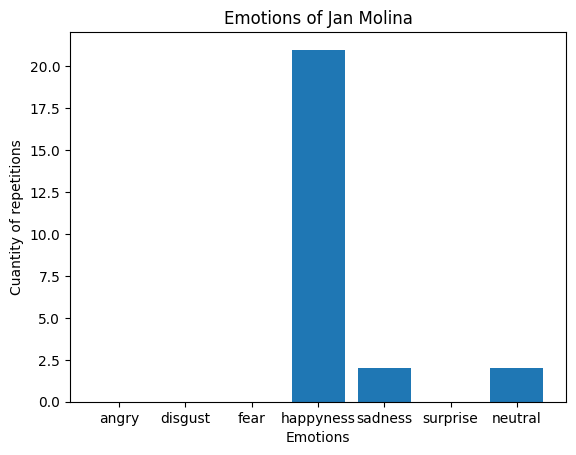

______________________________________________________________




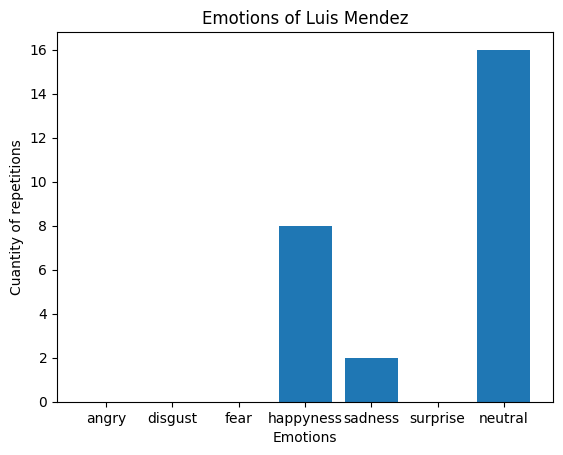

______________________________________________________________




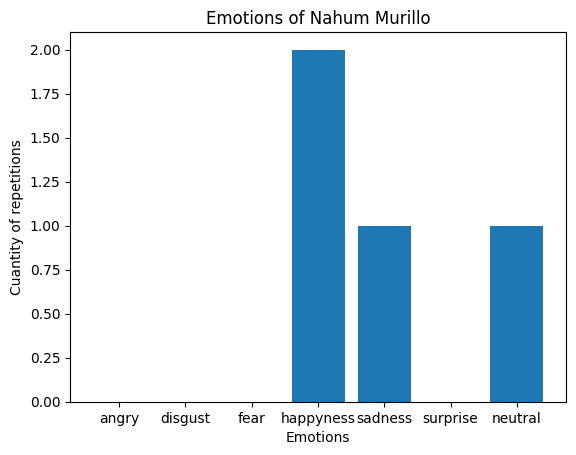

______________________________________________________________




In [ ]:
def consulta7():

  with open("Archivo_Entrevistado", "rb") as f:
      entrevistados = pickle.load(f)
  """
  This function will create a graph to compare all the emotions that
  each person had in the interview
  """

  # Each person is going to assign the variables of emotions at 0
  for person in entrevistados:
    emotions = []
    angry = 0
    disgust = 0
    fear = 0
    happyness = 0
    sadness = 0
    surprise = 0
    neutral = 0
    images = person.image
    image_info = images.get('Image_info')
    name = person.name

    # To each image, it will query the emotion and add it to a list
    for image in image_info:
      emotion = image[1]
      emotions.append(emotion)

    # If that emotion is found, 1 will be added to the variable of that emotion.
    for x in emotions:
      if x == "angry":
        angry += 1
      elif x == "disgust":
        disgust += 1
      elif x == "fear":
        fear += 1
      elif x == "happyness":
        happyness += 1
      elif x == "sadness":
        sadness += 1
      elif x == "surprise":
        surprise += 1
      elif x == "neutral":
        neutral += 1

    # It will create a graph with the data and with the help of the matplotlib.pyplot library    
    nombres = ['angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral']
    valores = [angry, disgust, fear, happyness, sadness, surprise, neutral]
    plt.bar(nombres, valores)
    plt.title("Emotions of "+ name)
    plt.xlabel('Emotions')
    plt.ylabel('Cuantity of repetitions')
    plt.show()
    print("______________________________________________________________")
    print()
    print()

consulta7()

In [ ]:
def evaluacion_contratacion():
    with open("Archivo_Entrevistado", "rb") as f:
        personas = pickle.load(f)

    for persona in personas:
        print("Información de la persona:")
        print(f"Nombre: {persona.name}")
        print(f"Identificación: {persona.ide}")
        print(f"Edad: {persona.age}")
        # Resto de la información de la persona

        # Realizar la evaluación de contratación
        evaluacion = input("Evaluación (contratado/no contratado): ")
        persona.estado = evaluacion
        print()
        print("Estado actualizado:", persona.estado)
        print()
        print("------------------------------------------")

    # Guardar los cambios en el archivo
    with open("Archivo_Entrevistado", "wb") as f:
        pickle.dump(personas, f)

# Llamar a la función para realizar la evaluación y actualizar los estados
evaluacion_contratacion()


## Aspectos administrativos


* La tarea será desarrollada en equipos de trabajo de máximo 2 personas.
* Cualquier acción de plagio será sancionada con una nota de 0 y la carta al expediente respectiva para todos los
implicados.
* La fecha de entrega será la semana 17, el día de clases, antes de la hora de clases.
* Para llevar el control de versiones del proyecto se debe crear un repositorio en GitLab y agregar al profesor (agregarlo
a la cuenta amendez.tec@gmail.com).
* Para llevar el control del las tareas a realizar por participante en el proyecto debe utilizar la herramienta
https://trello.com/es y compartir el link en el mismo Google Doc en que se comparte el link de la plantilla de Overleaf. Pueden crear tab de todas las tareas o requerimientos, un tab para las tareas en proceso y un tab para las tareas hechas.
* La codificación y documentación interna deberá ser desarrollada en idioma inglés utilizando el estándar docString de Python.
*La documentación externa debe estar redactada en idioma inglés utilizando la herramienta Overleaf (utilizar la plantilla facilitada por el profesor). La documentación es evaluada en el curso de Introducción a la programación.
* Documentación del Código utilizando Docstring Conventions 	
* Introducción a Python la Guía de Estilo de Código en Python
* La entrega será mediante la plataforma TecDigital en el espacio de Proyecto – Etapa 2. Lo que debe subir es un archivo de tipo notebook cuya extensión es (.ipynb). Además, en este archivo deben venir los enlaces a las imagenes utilizados para la tarea.
* Se recomienda que se empiece a trabajar lo antes posible.



# "La programación es una habilidad que puedes cultivar en ti mismo y usar para cambiar el mundo". - Barack Obama